In [205]:
!ls

2016PresidentialPrep.ipynb RI_Presidential_2016.xls
2016PresidentialRI.csv


In [206]:
# install geopandas and shapely
# !pip3 install geopandas
# !pip3 install shapely

In [207]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely import wkt
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

# Data Cleaning and Exploration

In [208]:
df = pd.read_excel("RI_Presidential_2016.xls")
df.head(10)

,Precinct Name,Precinct #,Total,E Day,Mail,Party,Office Title,Candidate,Vote for
0,Barrington 0101,101,2825,0,0,NaN,REGISTERED VOTERS - TOTAL,REGISTERED VOTERS - TOTAL,0
1,Barrington 0102,102,3182,0,0,NaN,REGISTERED VOTERS - TOTAL,REGISTERED VOTERS - TOTAL,0
2,Barrington 0103,103,2585,0,0,NaN,REGISTERED VOTERS - TOTAL,REGISTERED VOTERS - TOTAL,0
3,Barrington 0104,104,3118,0,0,NaN,REGISTERED VOTERS - TOTAL,REGISTERED VOTERS - TOTAL,0
4,Barrington 0105,105,3068,0,0,NaN,REGISTERED VOTERS - TOTAL,REGISTERED VOTERS - TOTAL,0
5,Barrington Limited,106,0,0,0,NaN,REGISTERED VOTERS - TOTAL,REGISTERED VOTERS - TOTAL,0
6,Barrington Presidential,107,0,0,0,NaN,REGISTERED VOTERS - TOTAL,REGISTERED VOTERS - TOTAL,0
7,Bristol 0201,201,1580,0,0,NaN,REGISTERED VOTERS - TOTAL,REGISTERED VOTERS - TOTAL,0
8,Bristol 0202,202,1021,0,0,NaN,REGISTERED VOTERS - TOTAL,REGISTERED VOTERS - TOTAL,0
9,Bristol 0203,203,2935,0,0,NaN,REGISTERED VOTERS - TOTAL,REGISTERED VOTERS - TOTAL,0


In [209]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36989 entries, 0 to 36988
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Precinct Name  36989 non-null  object
 1   Precinct #     36989 non-null  int64 
 2   Total          36989 non-null  int64 
 3   E Day          36989 non-null  int64 
 4   Mail           36989 non-null  int64 
 5   Party          21095 non-null  object
 6   Office Title   36989 non-null  object
 7   Candidate      36989 non-null  object
 8   Vote for       36989 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 2.5+ MB


In [210]:
df["Office Title"].unique()[:10]

array(['REGISTERED VOTERS - TOTAL', 'BALLOTS CAST - TOTAL',
       'Presidential Electors For:',
       'Representative in Congress District 1',
       'Representative in Congress District 2',
       'Senator in General Assembly District 1',
       'Senator in General Assembly District 2',
       'Senator in General Assembly District 3',
       'Senator in General Assembly District 4',
       'Senator in General Assembly District 5'], dtype=object)

## We only want Presidential Electors, drop all others

In [211]:
df = df[df["Office Title"] == "Presidential Electors For:"]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4008 entries, 1002 to 5009
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Precinct Name  4008 non-null   object
 1   Precinct #     4008 non-null   int64 
 2   Total          4008 non-null   int64 
 3   E Day          4008 non-null   int64 
 4   Mail           4008 non-null   int64 
 5   Party          3006 non-null   object
 6   Office Title   4008 non-null   object
 7   Candidate      4008 non-null   object
 8   Vote for       4008 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 313.1+ KB


## now we can drop some columns that we dont need
### keep  [Precinct Name, Precinct #, Total, Party, Candidate, Vote for]

In [212]:
df = df[["Precinct Name", "Precinct #", "Party", "Candidate", "Total"]]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4008 entries, 1002 to 5009
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Precinct Name  4008 non-null   object
 1   Precinct #     4008 non-null   int64 
 2   Party          3006 non-null   object
 3   Candidate      4008 non-null   object
 4   Total          4008 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 187.9+ KB


# read another csv and map county to this dataset

In [213]:
df2 = pd.read_csv("../../../../sec data/voting/presidential_2016/processed data/RI_presidential_2016.csv")

In [214]:
df2.head()

,county,precinct,candidate,party,votes,county_lat,county_long
0,Bristol County,Barrington 0101; 101,D. Trump,republican,522,41.70683,-71.28664
1,Bristol County,Barrington 0101; 101,G. Johnson,libertarian,60,41.70683,-71.28664
2,Bristol County,Barrington 0101; 101,H. Clinton,democratic,1027,41.70683,-71.28664
3,Bristol County,Barrington 0101; 101,J. Stein,green,23,41.70683,-71.28664
4,Bristol County,Barrington 0101; 101,other,other,39,41.70683,-71.28664


In [215]:
# generate county:precinct dict
c2p = dict()

for index, row in df2.iterrows():
    county = row["county"]
    precinct1, precinct2 = row["precinct"].split(";")
    precinct2 = precinct2.strip()
    
    if precinct2 in c2p.keys():
        if precinct1 in c2p[precinct2].keys():
            c2p[precinct2][precinct1].append(county)
        else:
            c2p[precinct2] = {precinct1: [county]}
    else:
        c2p[precinct2] = {}
        c2p[precinct2][precinct1] = [county]


In [216]:
# start filling in the county
df["County"] = np.nan
df = df.astype({'County': 'str'})

for index, row in df.iterrows():
    precinct1, precinct2 = row["Precinct Name"], str(row["Precinct #"])
    df.at[index, "County"] = c2p[precinct2][precinct1][0]

df["County"].unique()

array(['Bristol County', 'Providence County', 'Washington County',
       'Kent County', 'Newport County', nan], dtype=object)

In [217]:
df.head()

,Precinct Name,Precinct #,Party,Candidate,Total,County
1002,Barrington 0101,101,REP,Donald J. Trump,522,Bristol County
1003,Barrington 0102,102,REP,Donald J. Trump,683,Bristol County
1004,Barrington 0103,103,REP,Donald J. Trump,469,Bristol County
1005,Barrington 0104,104,REP,Donald J. Trump,611,Bristol County
1006,Barrington 0105,105,REP,Donald J. Trump,590,Bristol County


## lets see why party is missing alot values

In [218]:
dfCopy = df[pd.isna(df["Party"])]

In [219]:
dfCopy.head()

,Precinct Name,Precinct #,Party,Candidate,Total,County
4008,Barrington 0101,101,NaN,OVER VOTES,0,Bristol County
4009,Barrington 0102,102,NaN,OVER VOTES,2,Bristol County
4010,Barrington 0103,103,NaN,OVER VOTES,0,Bristol County
4011,Barrington 0104,104,NaN,OVER VOTES,1,Bristol County
4012,Barrington 0105,105,NaN,OVER VOTES,2,Bristol County


### see what candidates are missing Party

In [220]:
dfCopy["Candidate"].unique()

array(['OVER VOTES', 'UNDER VOTES'], dtype=object)

# Try to map each candidate to correct party
### we keeping only "democratic", "republican", "libertarian", "green"

In [221]:
# see all parties in df and all candidates
print(df["Party"].unique())
print(df["Candidate"].unique())

['REP' 'DEM' 'Lib' 'Grn' 'AMD' 'NON' nan]
['Donald J. Trump' 'Hillary Clinton' 'Gary Johnson' 'Jill Stein'
 '"Rocky" Roque  De La Fuente' 'WRITE-IN' 'OVER VOTES' 'UNDER VOTES']


In [222]:
candidate_to_keep = {'Hillary Clinton': "Democratic", 'Gary Johnson': "Libertarian",
                     'Jill Stein': "Green", 'Donald J. Trump': "Republican"}

In [223]:
# start normalizing "Party" and "Candidate" columns
print("#", end="")

for index, row in df.iterrows():
    if index%1000 == 0:
        print("=", end="")
        
    cur_candidate = row["Candidate"]
    if cur_candidate in candidate_to_keep.keys():
        df.at[index, "Party"] = candidate_to_keep[cur_candidate]
    else:
        df.at[index, "Candidate"] = "Other"
        df.at[index, "Party"] = "Other"
        
print("#", end="")

df["Party"].unique()

#====#

array(['Republican', 'Democratic', 'Libertarian', 'Green', 'Other'],
      dtype=object)

In [224]:
df["Candidate"].unique()

array(['Donald J. Trump', 'Hillary Clinton', 'Gary Johnson', 'Jill Stein',
       'Other'], dtype=object)

In [225]:
df.isnull().sum()

Precinct Name     0
Precinct #        0
Party             0
Candidate         0
Total             0
County           16
dtype: int64

# drop rows with county = Null

In [226]:
df[pd.isna(df["County"])]

,Precinct Name,Precinct #,Party,Candidate,Total,County
1501,Federal Precinct #1,9001,Republican,Donald J. Trump,30,NaN
1502,Federal Precinct #2,9002,Republican,Donald J. Trump,23,NaN
2002,Federal Precinct #1,9001,Democratic,Hillary Clinton,376,NaN
2003,Federal Precinct #2,9002,Democratic,Hillary Clinton,261,NaN
2503,Federal Precinct #1,9001,Libertarian,Gary Johnson,15,NaN
2504,Federal Precinct #2,9002,Libertarian,Gary Johnson,1,NaN
3004,Federal Precinct #1,9001,Green,Jill Stein,11,NaN
3005,Federal Precinct #2,9002,Green,Jill Stein,6,NaN
3505,Federal Precinct #1,9001,Other,Other,0,NaN
3506,Federal Precinct #2,9002,Other,Other,0,NaN


In [227]:
df.dropna(inplace=True)

In [228]:
df.isna().sum()

Precinct Name    0
Precinct #       0
Party            0
Candidate        0
Total            0
County           0
dtype: int64

In [229]:
# Sort the df by county then by precinct, then by candidate
df.sort_values(by=["County", "Precinct #", "Candidate"], inplace=True)

In [230]:
df.head()

,Precinct Name,Precinct #,Party,Candidate,Total,County
1002,Barrington 0101,101,Republican,Donald J. Trump,522,Bristol County
2004,Barrington 0101,101,Libertarian,Gary Johnson,60,Bristol County
1503,Barrington 0101,101,Democratic,Hillary Clinton,1027,Bristol County
2505,Barrington 0101,101,Green,Jill Stein,23,Bristol County
3006,Barrington 0101,101,Other,Other,2,Bristol County


# drop all precinct name that contains limited and presidential, these are unneeded (not in the precinct geographic data)

In [231]:
index2delete = df[df["Precinct Name"].str.contains("Presidential") | df["Precinct Name"].str.contains("Limited")].index
df.drop(index2delete, inplace=True)

# check if all deleted
df["Precinct Name"].str.contains("Limited").sum()

0

# make all precinct # 4 digits (so add a leading zero to 3 digit precinct #. By doing this we can map it to our geojson

In [232]:
# convert "Precinct #" to str
df = df.astype({'Precinct #': 'str'})

In [233]:
for index, row in df.iterrows():
    cur = row["Precinct #"]
    if len(cur) == 3:
        cur = "0" + cur
        df.at[index, "Precinct #"] = cur

# chec if all in 4 digit
df[df["Precinct #"].str.len() != 4]

,Precinct Name,Precinct #,Party,Candidate,Total,County


# merge data records by precinct # (so we endup with one row per precinct)

In [234]:
grouped = df.groupby(["Precinct #", "Precinct Name", "County", "Candidate", "Party"])
grouped.sum()

Total
Precinct # Precinct Name   County            Candidate       Party             
0101       Barrington 0101 Bristol County    Donald J. Trump Republican     522
                                             Gary Johnson    Libertarian     60
                                             Hillary Clinton Democratic    1027
                                             Jill Stein      Green           23
                                             Other           Other           59
...                                                                         ...
3912       Woonsocket 3912 Providence County Donald J. Trump Republican     448
                                             Gary Johnson    Libertarian     37
                                             Hillary Clinton Democratic     506
                                             Jill Stein      Green           18
                                             Other           Other           25

[2100 rows x 1 columns]

In [235]:
# new dataframe
columns = ["County", "Precinct Name", "Precinct #", "Hillary Clinton/Dem",
           "Donald J. Trump/Rep", "Gary Johnson/Lib", "Jill Stein/Grn",
           "Other/Other", "Total Votes"]
new_RI = pd.DataFrame(columns=columns)
new_RI.head()

,County,Precinct Name,Precinct #,Hillary Clinton/Dem,Donald J. Trump/Rep,Gary Johnson/Lib,Jill Stein/Grn,Other/Other,Total Votes


In [236]:
vote_column_name = {'Hillary Clinton': "Hillary Clinton/Dem", 
                    'Gary Johnson': "Gary Johnson/Lib", 'Jill Stein': "Jill Stein/Grn",
                    'Donald J. Trump': "Donald J. Trump/Rep", "Other": "Other/Other"}


# iterate the groupby df
print("################## Merging RI Dataframe ##################")

new_row = ""
cur_precinct = ""
total_votes = 0

for index, group in grouped:
    cur_row = group.loc[:].head(1)
    precinct = cur_row["Precinct #"].values[0]

    if precinct != cur_precinct:
        if cur_precinct != "":
            # add TotalVotes to new row
            new_row["Total Votes"] = total_votes
            # add new_row to new_RI dataframe
            new_RI = pd.concat([new_RI, new_row], ignore_index=True, sort=False)
            
        # reset vars
        cur_precinct = precinct
        new_row = ""
        total_votes = 0
    
    if type(new_row) == str:
        # get columns other than Total (Vote)
        new_row = cur_row[["County", "Precinct Name", "Precinct #"]]

    candidate_key = cur_row["Candidate"].values[0]
    new_row[vote_column_name[candidate_key]] = cur_row["Total"].values[0]
    total_votes += cur_row["Total"].values[0]
    
print("\n################ Done Merging RI Dataframe ###############")

################## Merging RI Dataframe ##################

################ Done Merging RI Dataframe ###############


In [237]:
new_RI.head(10)

,County,Precinct Name,Precinct #,Hillary Clinton/Dem,Donald J. Trump/Rep,Gary Johnson/Lib,Jill Stein/Grn,Other/Other,Total Votes
0,Bristol County,Barrington 0101,0101,1027,522,60,23,2,1634
1,Bristol County,Barrington 0102,0102,1331,683,68,21,3,2106
2,Bristol County,Barrington 0103,0103,1136,469,59,17,0,1681
3,Bristol County,Barrington 0104,0104,1328,611,78,25,2,2044
4,Bristol County,Barrington 0105,0105,1290,590,69,24,4,1977
5,Bristol County,Bristol 0201,0201,496,472,43,11,2,1024
6,Bristol County,Bristol 0202,0202,371,185,38,10,1,605
7,Bristol County,Bristol 0203,0203,1152,806,79,25,0,2062
8,Bristol County,Bristol 0204,0204,767,498,40,16,1,1322
9,Bristol County,Bristol 0205,0205,800,727,78,18,3,1626


In [238]:
new_RI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419 entries, 0 to 418
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   County               419 non-null    object
 1   Precinct Name        419 non-null    object
 2   Precinct #           419 non-null    object
 3   Hillary Clinton/Dem  419 non-null    object
 4   Donald J. Trump/Rep  419 non-null    object
 5   Gary Johnson/Lib     419 non-null    object
 6   Jill Stein/Grn       419 non-null    object
 7   Other/Other          419 non-null    object
 8   Total Votes          419 non-null    object
dtypes: object(9)
memory usage: 29.6+ KB


# load precinct geographic data

In [239]:
gdf = gpd.read_file('../../geographic/Precinct/RI_Precinct.json')
gdf.head(10)

,OBJECTID,NAME,Shape__Are,Shape__Len,geometry
0,1,0102,0.000348,0.153037,"MULTIPOLYGON (((-71.34122 41.73016, -71.34123 ..."
1,2,0101,0.000426,0.107569,"POLYGON ((-71.32270 41.77270, -71.32270 41.772..."
2,3,0104,0.000509,0.338228,"MULTIPOLYGON (((-71.30425 41.74515, -71.30425 ..."
3,4,0105,0.000520,0.297727,"MULTIPOLYGON (((-71.29308 41.71355, -71.29307 ..."
4,5,0103,0.000584,0.158078,"POLYGON ((-71.31979 41.73751, -71.31897 41.737..."
5,6,0203,0.000749,0.221845,"POLYGON ((-71.28006 41.70411, -71.28005 41.704..."
6,7,0202,0.000055,0.041161,"POLYGON ((-71.26938 41.66658, -71.26981 41.666..."
7,8,0209,0.000016,0.019530,"POLYGON ((-71.26850 41.67550, -71.26899 41.675..."
8,9,0208,0.000116,0.047580,"POLYGON ((-71.25903 41.67354, -71.25899 41.673..."
9,10,0205,0.000316,0.086892,"POLYGON ((-71.24882 41.70350, -71.24880 41.703..."


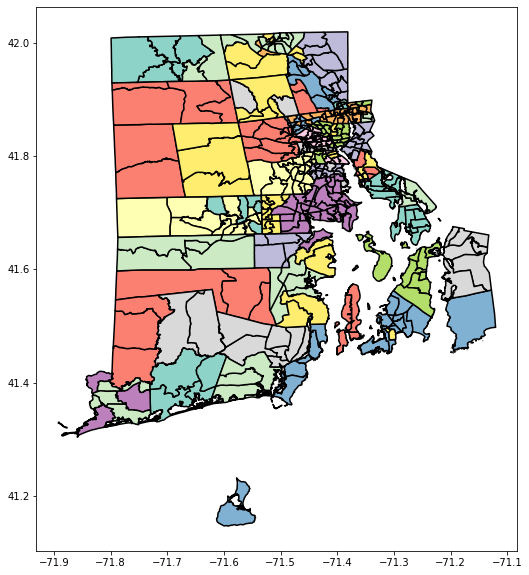

In [240]:
# plot the geojson
gdf.plot(linewidth=1.5, edgecolor="black", cmap='Set3', figsize=(13, 10))

# lets see if "precinct #" matches "NAME"

In [241]:
gdf_sorted = sorted(gdf["NAME"])
df_sorted = sorted(new_RI["Precinct #"].unique())
print(len(df_sorted), len(gdf_sorted))

419 419


In [242]:
# lets see if geographic data matches presidential
df_sorted.append("1")
df_sorted = sorted(df_sorted)
zipped = list(zip(gdf_sorted, df_sorted))

'''
for tup in list(zipped):
    v1, v2 = tup
    if v1 != v2:
        print(v1, v2)
        break
'''

'\nfor tup in list(zipped):\n    v1, v2 = tup\n    if v1 != v2:\n        print(v1, v2)\n        break\n'

In [243]:
# df
# add : 0729, 3912
# remove : 1018, 2631
delete_precinct = ["1018", "2631"]
index2delete = new_RI[new_RI["Precinct #"].isin(delete_precinct)].index
new_RI.drop(index2delete, inplace=True)

In [244]:
# add : 0729
# lets see which county should 0729 belong to, check 0728
row = new_RI[new_RI["Precinct #"] == "0728"]
row

,County,Precinct Name,Precinct #,Hillary Clinton/Dem,Donald J. Trump/Rep,Gary Johnson/Lib,Jill Stein/Grn,Other/Other,Total Votes
77,Providence County,Cranston 0728,0728,9,2,2,0,0,13


In [245]:
columns = ["Precinct Name", "Precinct #", "Hillary Clinton/Dem", "Donald J. Trump/Rep", 
           "Gary Johnson/Lib", "Jill Stein/Grn", "Other/Other", "Total Votes"]
values = ["Cranston 0729", "0729", 0, 0, 0, 0, 0, 0]
row.loc[77, columns] = values

# add to new_RI
new_RI = pd.concat([new_RI, row], ignore_index=True, sort=False)

In [246]:
# add : 3912
# found precinct 3912 data on SOS of RI
'''
Hillary Clinton (DEM) -- 506
Donald J. Trump (REP) -- 448
Gary Johnson (Lib) -- 37
Jill Stein (Grn) -- 18
Other -- 19
'''
row = new_RI[new_RI["Precinct #"] == "3911"]
row

,County,Precinct Name,Precinct #,Hillary Clinton/Dem,Donald J. Trump/Rep,Gary Johnson/Lib,Jill Stein/Grn,Other/Other,Total Votes
416,Providence County,Woonsocket 3911,3911,677,465,46,20,4,1212


In [247]:
columns = ["Precinct Name", "Precinct #", "Hillary Clinton/Dem", "Donald J. Trump/Rep", 
           "Gary Johnson/Lib", "Jill Stein/Grn", "Other/Other", "Total Votes"]
values = ["Woonsocket 3912", "3912", 506, 448, 37, 18, 19, 1028]
row.loc[416, columns] = values

# add to new_RI
new_RI = pd.concat([new_RI, row], ignore_index=True, sort=False)

In [248]:
new_RI[new_RI["Precinct #"] == "3912"]

,County,Precinct Name,Precinct #,Hillary Clinton/Dem,Donald J. Trump/Rep,Gary Johnson/Lib,Jill Stein/Grn,Other/Other,Total Votes
418,Providence County,Woonsocket 3912,3912,506,448,37,18,19,1028


In [249]:
df.sort_values(by=["Precinct #", "County", "Candidate"], inplace=True)
new_RI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419 entries, 0 to 418
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   County               419 non-null    object
 1   Precinct Name        419 non-null    object
 2   Precinct #           419 non-null    object
 3   Hillary Clinton/Dem  419 non-null    object
 4   Donald J. Trump/Rep  419 non-null    object
 5   Gary Johnson/Lib     419 non-null    object
 6   Jill Stein/Grn       419 non-null    object
 7   Other/Other          419 non-null    object
 8   Total Votes          419 non-null    object
dtypes: object(9)
memory usage: 29.6+ KB


# export the clean presidential file

In [250]:
new_RI.to_csv("2016PresidentialRI.csv")

array(['Bristol County', 'Providence County', 'Washington County',
       'Kent County', 'Newport County'], dtype=object)